<a href="https://colab.research.google.com/github/ShaheryarRafique/machine-learning/blob/main/logistic_regression_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split

In [3]:
# Path to your Google Drive folder
audio_folder = '/content/drive/My Drive/Recording_dataset'

# Empty lists to store features and labels
features = []
labels = []

# Loop over files
for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):

        # Get first two characters as language code
        lang_code = filename[:2]

        # Assign numeric label
        if lang_code == 'ur':
            label = 0
        elif lang_code == 'en':
            label = 1
        elif lang_code == 'eu':
            label = 2  # Assuming 'eu' = mixed
        else:
            continue

        file_path = os.path.join(audio_folder, filename)

        # Load audio
        audio, sr = librosa.load(file_path, sr=16000)

        # Extract 13 MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

        # Average MFCCs over time to get fixed-size vector
        mfcc_mean = np.mean(mfcc, axis=1)

        # Append x0 = 1 for bias term
        mfcc_with_bias = np.insert(mfcc_mean, 0, 1)

        # Store features and label
        features.append(mfcc_with_bias)
        labels.append(label)

print(f"Total samples processed: {len(features)}")

Total samples processed: 125


In [4]:
# Convert lists to numpy arrays
X = np.array(features)
y = np.array(labels)

print(f"Feature matrix shape: {X.shape}")  # (num_samples, 14)
print(f"Labels shape: {y.shape}")          # (num_samples,)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Feature matrix shape: (125, 14)
Labels shape: (125,)
Training samples: 100
Testing samples: 25


# **Softmax Function**

In [5]:
import numpy as np

def softmax(z):
    """
    z: shape (num_samples, num_classes)
    returns: probabilities, same shape
    """
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


# **Cross-Entropy Loss Function**

In [6]:
def cross_entropy_loss(y_true, y_pred):
    """
    y_true: (num_samples,) - actual class labels
    y_pred: (num_samples, num_classes) - predicted probabilities
    """
    num_samples = y_true.shape[0]
    # log probability of the correct class
    correct_log_probs = -np.log(y_pred[np.arange(num_samples), y_true] + 1e-15)
    loss = np.mean(correct_log_probs)
    return loss

# **Training Function with Gradient Descent**

In [7]:
def train_logistic_regression(X, y, num_classes=3, lr=0.1, epochs=500):
    num_samples, num_features = X.shape

    # Initialize weight matrix: shape (features, classes)
    W = np.zeros((num_features, num_classes))

    loss_history = []

    for epoch in range(epochs):
        # Step 1: Forward pass – compute scores
        scores = np.dot(X, W)  # shape: (samples, classes)

        # Step 2: Apply softmax to get class probabilities
        probs = softmax(scores)  # shape: (samples, classes)

        # Step 3: Compute loss
        loss = cross_entropy_loss(y, probs)
        loss_history.append(loss)

        # Step 4: Compute gradient
        y_one_hot = np.eye(num_classes)[y]  # Convert labels to one-hot
        gradient = np.dot(X.T, (probs - y_one_hot)) / num_samples

        # Step 5: Update weights
        W -= lr * gradient

        # Print loss occasionally
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

    return W, loss_history

# **Train Logistic Regression from Scratch**

In [11]:
W, loss_history = train_logistic_regression(X_train, y_train, num_classes=3, lr=0.1, epochs=600)

Epoch 1, Loss: 1.0986
Epoch 100, Loss: 11.0524
Epoch 200, Loss: 8.2893
Epoch 300, Loss: 8.9800
Epoch 400, Loss: 5.1808
Epoch 500, Loss: 3.1085
Epoch 600, Loss: 2.4177


# **Predict Function**

In [12]:
def predict(X, W):
    """
    X: feature matrix of shape (num_samples, num_features)
    W: learned weights of shape (num_features, num_classes)
    Returns: predicted class labels, shape (num_samples,)
    """
    scores = np.dot(X, W)  # compute raw scores
    probs = softmax(scores)  # apply softmax for probabilities
    predictions = np.argmax(probs, axis=1)  # pick class with highest prob
    return predictions

# **Evaluate Function**

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate(y_true, y_pred):
    """
    y_true: true class labels (array of shape (num_samples,))
    y_pred: predicted class labels (array of shape (num_samples,))
    """
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)

# **Full Evaluation Function**

In [17]:
from sklearn.metrics import classification_report

def full_evaluation(y_true, y_pred, labels=["Urdu", "English", "Mixed"]):
    """
    Prints precision, recall, F1-score for each class and macro averages.
    """
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=labels, digits=4))

In [18]:
y_pred = predict(X_test, W)

In [19]:
full_evaluation(y_test, y_pred)


Classification Report:

              precision    recall  f1-score   support

        Urdu     0.9091    0.9091    0.9091        11
     English     0.8571    1.0000    0.9231         6
       Mixed     1.0000    0.8750    0.9333         8

    accuracy                         0.9200        25
   macro avg     0.9221    0.9280    0.9218        25
weighted avg     0.9257    0.9200    0.9202        25



In [20]:
evaluate(y_test, y_pred)


Accuracy: 0.9200
Confusion Matrix:
[[10  1  0]
 [ 0  6  0]
 [ 1  0  7]]


# **Plotting Loss Curve**

In [21]:
import matplotlib.pyplot as plt

def plot_loss(loss_history, lr, label="Training Loss"):
    plt.plot(loss_history, label=f"{label}, lr={lr}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid()
    plt.legend()


Epoch 1, Loss: 1.0986
Epoch 100, Loss: 15.1971
Epoch 200, Loss: 15.1971
Epoch 300, Loss: 9.6709
Epoch 400, Loss: 9.6779
Epoch 500, Loss: 2.4177
Epoch 1, Loss: 1.0986
Epoch 100, Loss: 11.0524
Epoch 200, Loss: 8.2893
Epoch 300, Loss: 8.9800
Epoch 400, Loss: 5.1808
Epoch 500, Loss: 3.1085
Epoch 1, Loss: 1.0986
Epoch 100, Loss: 15.8878
Epoch 200, Loss: 13.8155
Epoch 300, Loss: 10.3616
Epoch 400, Loss: 10.0162
Epoch 500, Loss: 2.4177


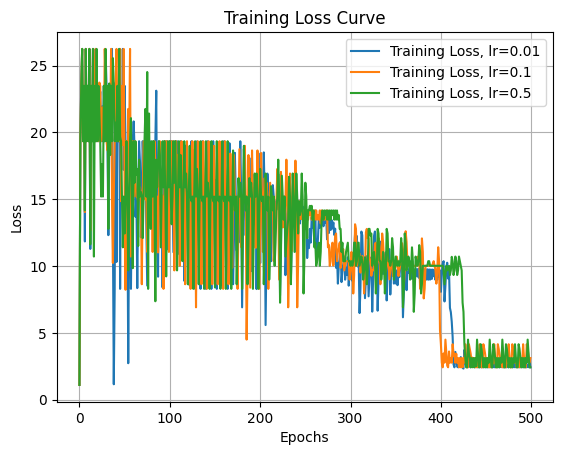

In [22]:
lrs = [0.01, 0.1, 0.5]
epochs = 500

for lr in lrs:
    _, loss_history = train_logistic_regression(X_train, y_train, lr=lr, epochs=epochs)
    plot_loss(loss_history, lr)


In [23]:
plt.show()
